#Preprocessing Data

In [2]:
import torch
print(torch.cuda.is_available())

torch.cuda.current_device()

torch.cuda.device(0)

torch.cuda.device_count()

torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 4090'

In [3]:
# !pip install transformers torch


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Define the input and output file paths
input_file_path = '1q84.txt'
output_file_path = 'new_1q84.txt'

# Read all lines from the file
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

print("First look at the files: \n", lines)

# Join lines to form a single string
content = ''.join(lines)

# Find the position of the "Reader’s Guide" string
reader_guide_pos = content.find("Reader’s Guide")

# If "Reader’s Guide" is found, slice the content from that position
if reader_guide_pos != -1:
    content = content[reader_guide_pos:]
else:
    print("The string 'Reader’s Guide' was not found in the file.")

# Split the sliced content back into lines
lines = content.splitlines(keepends=True)


# Filter out blank lines
non_blank_lines = [line for line in lines if line.strip()]

# Write the non-blank lines back to a new file
with open(output_file_path, 'w', encoding='utf-8') as file:
    file.writelines(non_blank_lines)


print(f"Cleared and filtered content written to {output_file_path}")


First look at the files: 
 ['FICTION\n', '\n', 'AFTER DARK\n', '\n', 'AFTER THE QUAKE\n', '\n', 'BLIND WILLOW, SLEEPING WOMAN\n', '\n', 'DANCE DANCE DANCE\n', '\n', 'THE ELEPHANT VANISHES\n', '\n', 'HARD-BOILED WONDERLAND AND THE END OF THE WORLD\n', '\n', 'KAFKA ON THE SHORE\n', '\n', 'NORWEGIAN WOOD\n', '\n', 'SOUTH OF THE BORDER, WEST OF THE SUN\n', '\n', 'SPUTNIK SWEETHEART\n', '\n', 'A WILD SHEEP CHASE\n', '\n', 'THE WIND-UP BIRD CHRONICLE\n', '\n', '\n', '\n', '\n', '\n', 'NONFICTION\n', '\n', 'UNDERGROUND: THE TOKYO GAS ATTACK\n', '\n', 'AND THE JAPANESE PSYCHE\n', '\n', 'WHAT I TALK ABOUT WHEN I TALK ABOUT RUNNING:\n', '\n', 'A MEMOIR\n', '\n', '\n', '\n', '\n', '\n', 'Translation copyright © 2011 by Haruki Murakami.\n', '\n', 'All rights reserved.\n', '\n', 'Published in the United States by Alfred A. Knopf, a division of Random House, Inc., New York.\n', '\n', 'www.aaknopf.com\n', '\n', 'Knopf, Borzoi Books, and the colophon are registered trademarks of Random House, Inc.\n',

In [6]:
with open(output_file_path, 'r', encoding='utf-8') as file:
    txt_lines = file.readlines()
print(txt_lines)

['Reader’s Guide\n', 'BOOK 1 APRIL-JUNE\n', 'CHAPTER 1\n', 'Aomame\n', 'DON’T LET APPEARANCES FOOL YOU\n', 'The taxi’s radio was tuned to a classical FM broadcast. Janáček’s Sinfonietta—probably not the ideal music to hear in a taxi caught in traffic. The middle-aged driver didn’t seem to be listening very closely, either. With his mouth clamped shut, he stared straight ahead at the endless line of cars stretching out on the elevated expressway, like a veteran fisherman standing in the bow of his boat, reading the ominous confluence of two currents. Aomame settled into the broad back seat, closed her eyes, and listened to the music.\n', 'How many people could recognize Janáček’s Sinfonietta after hearing just the first few bars? Probably somewhere between “very few” and “almost none.” But for some reason, Aomame was one of the few who could.\n', 'Janáček composed his little symphony in 1926. He originally wrote the opening as a fanfare for a gymnastics festival. Aomame imagined 1926 Cz

In [7]:
# !pip install datasets

In [8]:
from datasets import load_dataset

# Assuming your file is named "summarization_data.txt" with Option 2 structure
dataset = load_dataset("text", data_files={"train": "new_1q84.txt"})

Generating train split: 0 examples [00:00, ? examples/s]

# BART From PDF to PDF

In [9]:
# !pip install PyMuPDF

In [11]:
import tensorflow as tf
print(tf.test.gpu_device_name())

ModuleNotFoundError: No module named 'tensorflow'

In [10]:
from transformers import BartForConditionalGeneration, BartTokenizer
import textwrap
import fitz  # PyMuPDF


ModuleNotFoundError: No module named 'fitz'

In [ ]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc[page_num]
        text += page.get_text()
    doc.close()
    return text

In [ ]:
def text_summarizer_from_pdf(pdf_path):
    pdf_text = extract_text_from_pdf(pdf_path)

    model_name = "facebook/bart-large-cnn"
    model = BartForConditionalGeneration.from_pretrained(model_name)
    tokenizer = BartTokenizer.from_pretrained(model_name)

    inputs = tokenizer.encode("summarize: " + pdf_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    formatted_summary = "\n".join(textwrap.wrap(summary, width=80))
    return formatted_summary

In [ ]:
def save_summary_as_pdf(pdf_path, summary):
    doc = fitz.open()

    page = doc.new_page()
    page.insert_text((10, 100), summary, fontname="helv", fontsize=12)  # Adjust the vertical position as needed

    output_pdf_path = pdf_path.replace(".pdf", "_summary.pdf")
    doc.save(output_pdf_path)
    doc.close()

    return output_pdf_path

In [ ]:
pdf_file_path = "./new_1q84.txt"
# pdf_file_path = "/drive/MyDrive/new_1q84.pdf"
summary = text_summarizer_from_pdf(pdf_file_path)
output_pdf_path = save_summary_as_pdf(pdf_file_path, summary)
print("Summary saved as PDF:", output_pdf_path)

Summary saved as PDF: ./new_1q84.txt


# Fine Tuning Using Dialogue

In [ ]:
# !pip install datasets

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import random
import os
from datasets import load_dataset

# Load the BART model and tokenizer
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# !pip install py7zr

In [ ]:
samsum = load_dataset('samsum')
samsum

c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

In [ ]:
# !pip install pandas matplotlib

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

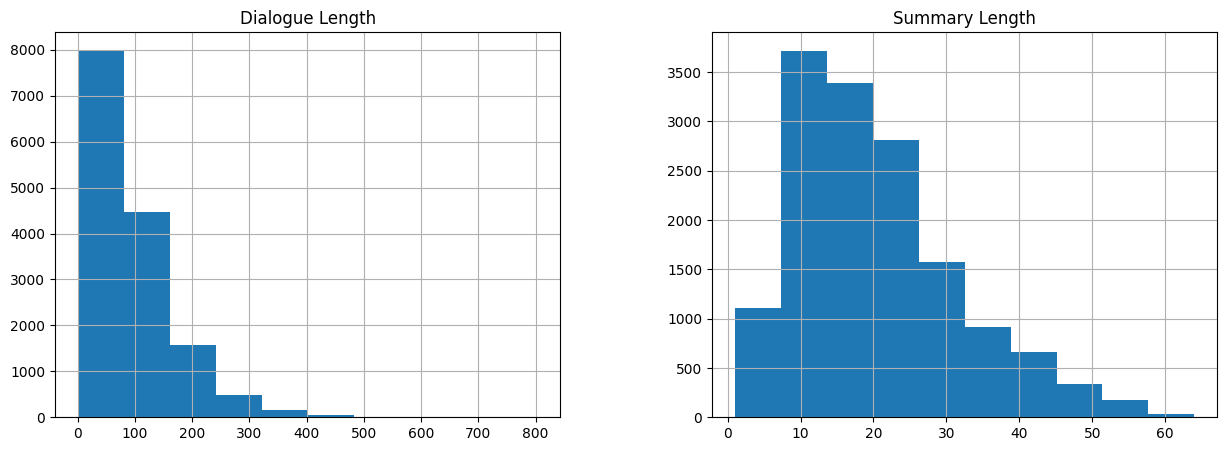

In [ ]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [ ]:
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
samsum_pt = samsum.map(get_feature, batched=True)

Map: 100%|██████████| 819/819 [00:00<00:00, 8027.55 examples/s]


In [ ]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# !pip install transformers[torch]

In [ ]:
# !pip install -U accelerate

In [ ]:
# !pip install -U transformers

In [ ]:
# !pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:646: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


TrainOutput(global_step=230, training_loss=1.4832090294879416, metrics={'train_runtime': 1834.5552, 'train_samples_per_second': 8.03, 'train_steps_per_second': 0.125, 'total_flos': 8823027777404928.0, 'train_loss': 1.4832090294879416, 'epoch': 0.9991854466467553})

In [ ]:
trainer.save_model('bart_samsum_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

#Fine Tuning using BBC Dataset

In [11]:
import torch
print(torch.cuda.is_available())

torch.cuda.current_device()

torch.cuda.device(0)

torch.cuda.device_count()

torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 4090'

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bbc-news-summary:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F24984%2F32267%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T085839Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7115542e99cf1c197a054cef1d8eaa964b08f3a78c09634590d5bcea1d00d6bead3ca54a5f91f25d330f8b0fa57616033ae1f454f8662dc98b042a7f431a90bc498fb0512eac455b255c5d59b05bdc89071bb17a1e07147375f5679d3b688085526cd359d397bc701405ba91177088967298032311ffe0bd1ce8206d009eefa6b74fc3b4dda68332db1bf5b03454df39e18b62906335de4e89316a4dee09ddc4d3738c378467c808bfb942bd40ae18daa87e3c2688f5c328591637e5a87d0e2a5bc9893af0d4829cc6ae3dac6c4ea7917620c5a2d8a714328055dceee7fba2bdb143f9b2ec211491dc2636caf82b2046ee77019d6d3bcc7c92515ee6cb8dfe49'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

KAGGLE_INPUT_PATH='./input'
KAGGLE_WORKING_PATH='./working'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
shutil.rmtree(KAGGLE_INPUT_PATH, ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join(".", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join(".", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9342346 bytes downloaded
Downloaded and uncompressed: bbc-news-summary
Data source import complete.


In [2]:
# !pip install nltk seaborn numpy

In [2]:
import nltk # Imports the library
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import os

In [3]:
paths = os.listdir('./input/bbc-news-summary/BBC News Summary/News Articles')
articles_path = './input/bbc-news-summary/BBC News Summary/News Articles/'
summaries_path = './input/bbc-news-summary/BBC News Summary/Summaries/'

articles = []
summaries = []
file_arr = []

for path in paths:
    files = os.listdir(articles_path + path)
    for file in files:
        article_file_path = articles_path + path + '/' + file
        summary_file_path = summaries_path + path + '/' + file
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(path + '/' + file)
        except:
            pass

In [4]:
pd.set_option('display.max_colwidth', 200)
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head(2)

path  \
0  business/001.txt   
1  business/002.txt   

                                                                                                                                                                                                   article  \
0  Ad sales boost Time Warner profit..Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier...The firm, which is now o...   
1  Dollar gains on Greenspan speech..The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise...And Al...   

                                                                                                                                                                                                   summary  
0  TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09b...  
1  The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.China's currency remains pegged to the dol...

In [5]:
# Function to count the number of words in a text
def count_words(text):
    return len(text.split())

df['wordcnt_article'] = df['article'].apply(count_words)
df['wordcnt_summary'] = df['summary'].apply(count_words)
df.head(2)


path  \
0  business/001.txt   
1  business/002.txt   

                                                                                                                                                                                                   article  \
0  Ad sales boost Time Warner profit..Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier...The firm, which is now o...   
1  Dollar gains on Greenspan speech..The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise...And Al...   

                                                                                                                                                                                                   summary  \
0  TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09b...   
1  The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.China's currency remains pegged to the dol...   

   wordcnt_article  wordcnt_summary  
0              416              134  
1              381              158

In [6]:
df.describe()

wordcnt_article  wordcnt_summary
count      2224.000000      2224.000000
mean        379.286871       165.151529
std         235.081995       108.678038
min          87.000000        38.000000
25%         242.000000       103.000000
50%         327.000000       142.000000
75%         465.250000       202.000000
max        4377.000000      2073.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             2224 non-null   object
 1   article          2224 non-null   object
 2   summary          2224 non-null   object
 3   wordcnt_article  2224 non-null   int64 
 4   wordcnt_summary  2224 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 87.0+ KB


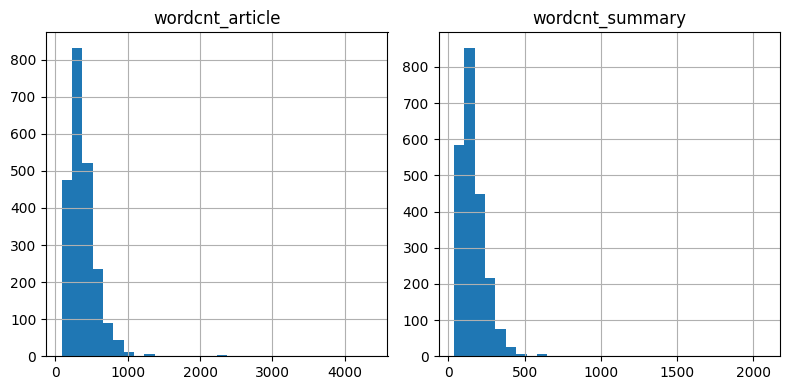

In [8]:
numerical_columns = df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))  # Adjust 'bins' and 'figsize' as needed
plt.tight_layout()  # Ensure proper spacing between plots

plt.show()

In [9]:
filtered_df = df[df['wordcnt_article'] < 400]
filtered_df.describe()

wordcnt_article  wordcnt_summary
count      1429.000000      1429.000000
mean        265.725682       115.603219
std          71.062142        32.977902
min          87.000000        38.000000
25%         213.000000        91.000000
50%         263.000000       114.000000
75%         319.000000       139.000000
max         399.000000       211.000000

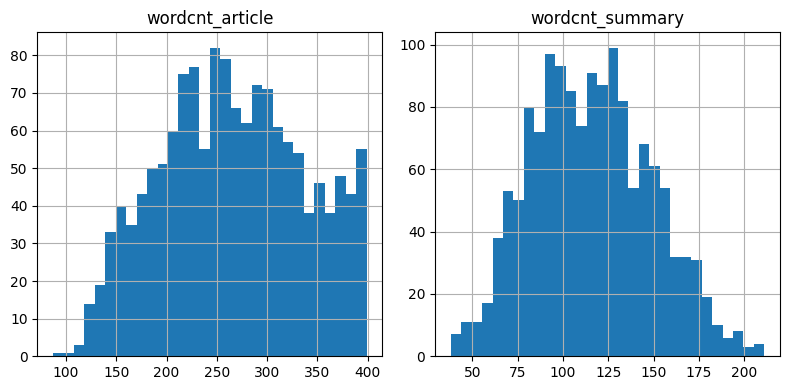

In [10]:
numerical_columns = filtered_df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))  # Adjust 'bins' and 'figsize' as needed
plt.tight_layout()  # Ensure proper spacing between plots

plt.show()

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 1 to 2222
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             1429 non-null   object
 1   article          1429 non-null   object
 2   summary          1429 non-null   object
 3   wordcnt_article  1429 non-null   int64 
 4   wordcnt_summary  1429 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 67.0+ KB


In [12]:
# Drop columns from the DataFrame
filtered_df = filtered_df.drop(['wordcnt_article', 'wordcnt_summary', 'path'], axis=1)

# Check the information of the updated DataFrame
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 1 to 2222
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  1429 non-null   object
 1   summary  1429 non-null   object
dtypes: object(2)
memory usage: 33.5+ KB


In [13]:
# Calculate the number of rows to sample (30% of the original data)
sample_size = int(0.3 * len(filtered_df))

# Sample 30% of the data
sampled_df = filtered_df.sample(n=sample_size, random_state=42)  # You can choose any random_state value for reproducibility
sampled_df.head(3)

article  \
151   Crude oil prices back above $50..Cold weather across parts of the United States and much of Europe has pushed US crude oil prices above $50 a barrel for the first time in almost three months...Fre...   
1732  Henman overcomes rival Rusedski..Tim Henman saved a match point before fighting back to defeat British rival Greg Rusedski 4-6 7-6 (8-6) 6-4 at the Dubai Tennis Championships on Tuesday...World nu...   
584   Indie film nominations announced..Mike Leigh's award-winning abortion drama Vera Drake has scooped seven nominations at this year's British Independent Film Awards...But the Venice winner faces st...   

                                                                                                                                                                                                      summary  
151   Cold weather across parts of the United States and much of Europe has pushed US crude oil prices above $50 a barrel for the first time in almost three months.Several Opec members said a cut in pro...  
1732  Rusedski had match point at 6-5 in the second set tie-break after Henman double-faulted, but missed his chance and Henman rallied to clinch the set.It was the first match between the pair for thre...  
584   Considine is also nominated for a best supporting actor award for My Summer of Love.Joining Vera Drake and Dead Man's Shoes in the running for best film are My Summer of Love, climbing documentary...

In [14]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 151 to 681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  428 non-null    object
 1   summary  428 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB


In [15]:
df=sampled_df

In [16]:
# !pip install rouge-score

In [ ]:
# !pip install -U scikit-learn

In [18]:
!pip install scikit-learn

  Using cached scikit_learn-1.4.2-cp39-cp39-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp39-cp39-win_amd64.whl (10.6 MB)


In [16]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_


c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

# Define the device for GPU usage (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU


df['TokenizedText'] = df['article'].apply(tokenize_text)
df['TokenizedSummary'] = df['summary'].apply(tokenize_summary)

# Split your data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert tokenized data to PyTorch tensors
X_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedText']])
Y_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedSummary']])
X_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedText']])
Y_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedSummary']])

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)


In [18]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

# Define gradient accumulation steps
accumulation_steps = 20  # You can adjust this number

def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def calculate_rouge1_precision(logits, targets):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_precision = 0.0
    num_samples = len(logits)

    for i in range(num_samples):
        predicted_ids = logits[i].cpu().numpy()
        target_ids = targets[i].cpu().numpy()

        # Convert token IDs to strings
        predicted_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)
        target_text = tokenizer.decode(target_ids, skip_special_tokens=True)

        # Calculate ROUGE-1 precision
        scores = scorer.score(predicted_text, target_text)
        rouge1_precision += scores['rouge1'].precision

    return rouge1_precision / num_samples

# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")




c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/86 [00:00<?, ?it/s]c:\Users\IBDA\.conda\envs\ongtitin\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 86/86 [08:47<00:00,  6.13s/it]


Epoch 1/2, Train Loss: 0.6950


Training: 100%|██████████| 86/86 [08:51<00:00,  6.18s/it]

Epoch 2/2, Train Loss: 0.6937


In [19]:
def evaluate(model, dataloader):
    model.eval()

    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)

            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)

                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate(model, test_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}

# Create a Pandas DataFrame from the dictionary
results_df = pd.DataFrame(data)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
results_df.head(5)

Evaluating Test: 100%|██████████| 22/22 [14:16<00:00, 38.95s/it]


Article  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    summarize: Versace art portfolio up for sale..The art collection of murdered fashion designer Gianni Versace could fetch up to £9m ($17m) when it is auctioned in New York and London later this year...Among the pictures for sale are works by Roy Lichtenstein, Andy Warhol and Henri Matisse. The collection was housed at Versace's six-storey New York townhouse. The 51-year-old designer was shot outside his Florida home in 1997 by suspected serial killer Andrew Cunanan, who later killed himself. The auction, at Sotheby's, will feature 45 contemporary, impressionist and 19th Century paintings. One of the highlights of the sale is Roy Lichtenstein's Blue Nude which has been given an estimate of £1.8m ($3.4m)...Tobias Meyer, Sotheby's worldwide head of contemporary art, said: "This collection reflects Mr Versace's wide-ranging taste and impeccable eye, and many of the works were commissioned directly from the artists. "Outstanding later examples from champions of the Pop movement, such as Roy Lichtenstein, are juxtaposed with masterpieces from the most visible artists of the 1980's, including Jean-Michel Basquiat and the collaborative genius of Basquiat and Warhol, as well as Francesco Clemente." Much of the collection will be offered for sale at three auctions in New York in June, with smaller contemporary paintings going under the hammer in London on 22 and 23 June. A sale of Versace's furniture and artworks sold in 2001fetched £5.5m ($10.3m).   
1  summarize: Talks aim to avert pension strike..Talks aimed at averting a series of national strikes over pensions reforms will take place this weekend...Five public sector unions will hold private talks with Deputy Prime Minister John Prescott at Labour's spring conference in Gateshead. They want the government to withdraw regulations - due to be introduced in weeks - which would raise the pension age for council workers from 60 to 65. Up to 1.4m workers could take part in a strike already earmarked for 23 March. However, all sides are anxious to avoid a major confrontation in the run up to the general election, said BBC labour affairs correspondent Stephen Cape. In four days, Britain's biggest union Unison will start balloting 800,000 local government workers on strikes. Other public sector unions have pledged to follow. It is just weeks before new regulations are introduced to raise the pension age of local government workers...The five unions meeting Mr Prescott want the government to withdraw these regulations. This would allow months of tough negotiations to follow, said our correspondent. But a spokesman for Mr Prescott warned that the changes to the local government pension scheme would have to go ahead in April. Privately ministers believe this will be the "less painful" option, our correspondent added. The Public and Commercial Services Union (PCS) will co-ordinate any industrial action with up to six other public sector unions. PCS leader Mark Serwotka warned last week that there could be further walkouts unless there was a government rethink. "For a government that lectures everyone on choice - choice on public service, choice on this and choice 

In [20]:
pd.set_option('display.max_colwidth', 100)

results_df.head(20)

Article  \
0   summarize: Versace art portfolio up for sale..The art collection of murdered fashion designer Gi...   
1   summarize: Talks aim to avert pension strike..Talks aimed at averting a series of national strik...   
2   summarize: Blinx sequel purrs nicely..The original Blinx was intended to convert many platform g...   
3   summarize: MCI shareholder sues to stop bid..A shareholder in US phone firm MCI has taken legal ...   
4   summarize: Pop band Busted to 'take a break'..Chart-topping pop band Busted have confirmed that ...   
5   summarize: O'Sullivan quick to hail Italians..Ireland coach Eddie O'Sullivan heaped praise on It...   
6   summarize: Anti-spam laws bite spammer hard..The net's self-declared spam king is seeking bankru...   
7   summarize: Roxy Music on Isle of Wight bill..Roxy Music will appear at June's Isle of Wight musi...   
8   summarize: More movies head to Sony's PSP..Movies Open Water and Saw are among those to be made ...   
9   summarize: Holmes urged to compete at Worlds..Jolanda Ceplak has urged Britain's Kelly Holmes to...   
10  summarize: Hotspot users gain free net calls..People using wireless net hotspots will soon be ab...   
11  summarize: Charvis set to lose fitness bid..Flanker Colin Charvis is unlikely to play any part i...   
12  summarize: SFA awaits report over Mikoliunas..The Scottish Football Association is awaiting refe...   
13  summarize: Weir poised for Sunderland move..Larne's teenage star Robbie Weir is poised to join S...   
14  summarize: England 'to launch ref protest'..England will protest to the International Rugby Boar...   
15  summarize: Howard 'truanted to play snooker'..Conservative leader Michael Howard has admitted he...   
16  summarize: Macy's owner buys rival for $11bn..US retail giant Federated Department Stores is to ...   
17  summarize: UK homes hit £3.3 trillion total..The value of the UK's housing stock reached the £3....   
18  summarize: Hillbillies singer Scoggins dies..Country and Western musician Jerry Scoggins has die...   
19  summarize: Bryan twins keep US hopes alive..The United States kept the Davis Cup final alive wit...   

                                                                                         Actual Summary  \
0   Much of the collection will be offered for sale at three auctions in New York in June, with smal...   
1   The five unions meeting Mr Prescott want the government to withdraw these regulations.They want ...   
2   The original Blinx was intended to convert many platform game lovers to Microsoft's then new Xbo...   
3   A shareholder in US phone firm MCI has taken legal action to halt a $6.75bn (£3.6bn) buyout by t...   
4   Chart-topping pop band Busted have confirmed that they plan to "take a break", following rumours...   
5   "It was a hell of a tough game," said O'Sullivan."We had our first attack in the Italian half af...   
6   OptInRealBig was fighting several legal battles, most notably against Microsoft, which is pushin...   
7   Morrissey will also play on Saturday at the festival, while Supergrass and Idlewild have been co...   
8   Four movies have already been announced for PSP.Film studio Lions Gate entertainment has announc...   
9   Ceplak added: "I like running against her - you know the race is always going to be fast.Ceplak ...   
10  Skype allows people to make free PC-based calls to other Skype users.Users will need a Skype acc...   
11  Flanker Colin Charvis is unlikely to play any part in Wales' final two games of the Six Nations....   
12  "We don't know how many red cards he was shown," said an SFA statement.Rangers' striker Dad Prso...   
13  ''Robbie has an agreement with Larne that he can negotiate with interested clubs.But it would be...   
14  England will protest to the International Rugby Board (IRB) about the referee's performance in t...   
15  Mr Howard said his time at Jack's Snooker Hall in Llanelli in the 1950s had not done him "any la...   
16  US retail giant Federated

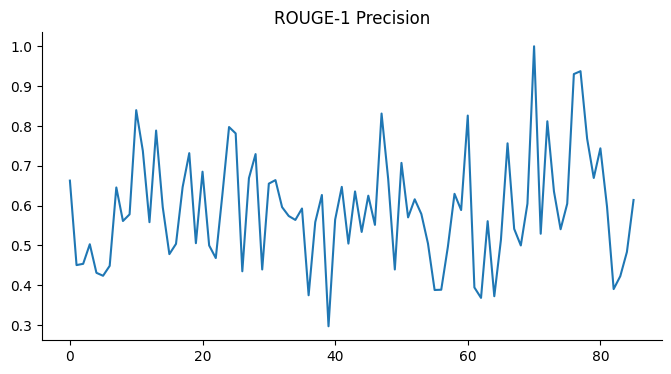

In [21]:
# @title ROUGE-1 Precision

from matplotlib import pyplot as plt
results_df['ROUGE-1 Precision'].plot(kind='line', figsize=(8, 4), title='ROUGE-1 Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

In [22]:
model.save_pretrained(save_directory='saved_models')
tokenizer.save_pretrained(save_directory='saved_models')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('saved_models\\tokenizer_config.json',
 'saved_models\\special_tokens_map.json',
 'saved_models\\vocab.json',
 'saved_models\\merges.txt',
 'saved_models\\added_tokens.json')

#Making Sumarization With LSTM

In [ ]:
# !kaggle datasets download -d snap/amazon-fine-food-reviews

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# !pip install tensorflow

In [ ]:
# !pip install beautifulsoup4

In [ ]:
# !pip install keras keras-Preprocessing tensorflow

In [21]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [22]:
from attention import AttentionLayer

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
data=pd.read_csv("Reviews.csv",nrows=100000)

In [25]:

data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [26]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [29]:

data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [30]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [31]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [32]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

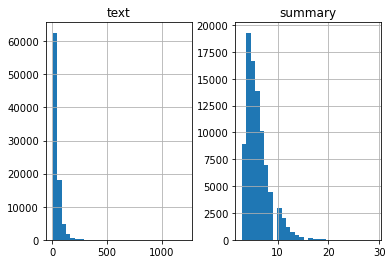

In [33]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [34]:
max_len_text=80
max_len_summary=10

In [35]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [36]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [37]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [38]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      25785500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [41]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50


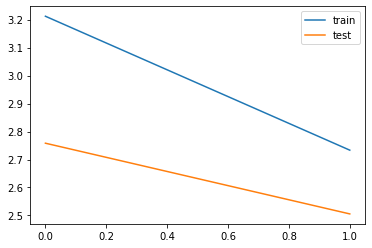

In [ ]:

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  #print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: ordered salmon thursday january received january salmon delicious wooden box nice design used store items future 
Original summary: alaska smokehouse smoked salmon 


Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 


Review: variety granola one ranks top favorites crunch granola coconut main taste sweet overly eat snack craving something fills fast satisfies sugar cravings 
Original summary: great taste 


Review: bought dollar tree yummy taste like french fries crunchy going b

In [ ]:
model.save('my_summarize_lstm.h5')

## TEST For BART Pretrained

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Load the pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# Example article to summarize
article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

# Tokenize the article and prepare input for the model
inputs = tokenizer.encode("summarize: " + article, return_tensors="pt", max_length=1024, truncation=True)

# Generate the summary using the BART model
summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Calculate the BLEU score
reference_summary = "The Eiffel Tower is a global cultural icon of France and the most visited paid monument in the world."
reference = [tokenizer.tokenize(reference_summary)]
candidate = [tokenizer.tokenize(summary)]
bleu_score = corpus_bleu(reference, candidate)

print(reference_summary)
print(summary)

# Calculate the ROUGE score
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = rouge_scorer.score(reference_summary, summary)

# Print the BLEU and ROUGE scores
print("BLEU score:", bleu_score)
print("ROUGE scores:")
print("  ROUGE-1:", rouge_scores['rouge1'].fmeasure)
print("  ROUGE-2:", rouge_scores['rouge2'].fmeasure)
print("  ROUGE-L:", rouge_scores['rougeL'].fmeasure)

# scores = np.array([rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure, bleu_score])
# labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
# colors = ['blue', 'green', 'red', 'purple']
# plt.bar(range(len(scores)), scores, color=colors)
# plt.xticks(range(len(scores)), labels, rotation=45)
# plt.xlabel('Metrics')
# plt.ylabel('Scores')
# plt.title('ROUGE and BLEU Scores for BART-based Summarization')
# plt.show()

The Eiffel Tower is a global cultural icon of France and the most visited paid monument in the world.
The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it has become a global cultural icon of France.
BLEU score: 6.851187014592609e-232
ROUGE scores:
  ROUGE-1: 0.47457627118644063
  ROUGE-2: 0.3157894736842105
  ROUGE-L: 0.3389830508474576


c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

## TEST For BART Fine Tune

In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Load the fine-tuned BART model and tokenizer
model_name = "saved_models"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# Example article to summarize
article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

# Tokenize the article and prepare input for the model
inputs = tokenizer.encode("summarize: " + article, return_tensors="pt", max_length=1024, truncation=True)

# Generate the summary using the BART model
summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Calculate the BLEU score
reference_summary = "The Eiffel Tower is a global cultural icon of France and the most visited paid monument in the world."
reference = [tokenizer.tokenize(reference_summary)]
candidate = [tokenizer.tokenize(summary)]
bleu_score = corpus_bleu(reference, candidate)

print(reference_summary)
print(summary)

# Calculate the ROUGE score
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = rouge_scorer.score(reference_summary, summary)

# Print the BLEU and ROUGE scores
print("BLEU score:", bleu_score)
print("ROUGE scores:")
print("  ROUGE-1:", rouge_scores['rouge1'].fmeasure)
print("  ROUGE-2:", rouge_scores['rouge2'].fmeasure)
print("  ROUGE-L:", rouge_scores['rougeL'].fmeasure)

The Eiffel Tower is a global cultural icon of France and the most visited paid monument in the world.
summarize: The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffell, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The E-shaped tower is the most-visited paid monument in the United States, with more than 1.5 million people visiting it in 2015.
BLEU score: 5.364699661127006e-232
ROUGE scores:
  ROUGE-1: 0.2992125984251968
  ROUGE-2: 0.272
  ROUGE-L: 0.28346456692913385


c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\IBDA\.conda\envs\jjm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

## TEST For LSTM

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from attention import AttentionLayer

In [4]:
model_path = "my_summarize_lstm.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})

# Load tokenizers
with open('text_tokenizer.pkl', 'rb') as handle:
    text_tokenizer = pickle.load(handle)

with open('summary_tokenizer.pkl', 'rb') as handle:
    summary_tokenizer = pickle.load(handle)

In [5]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "cause": "because", "could've": "could have", "couldn't": "could not",
}

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = [i for i in tokens if len(i) >= 3]
    return " ".join(long_words).strip()

In [7]:
article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

cleaned_article = text_cleaner(article)

In [8]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts([cleaned_article])

In [9]:
target_summary = "The Eiffel Tower is a global cultural icon of France and the most visited paid monument in the world."

In [10]:
cleaned_summary = text_cleaner(target_summary)

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts([cleaned_summary])

In [11]:
max_text_len = 80  # Adjust according to your model's input size
article_sequence = text_tokenizer.texts_to_sequences([cleaned_article])
article_sequence = pad_sequences(article_sequence, maxlen=max_text_len, padding='post')

In [12]:
max_summary_len = 10  # Adjust according to your model's output size
summary_sequence = summary_tokenizer.texts_to_sequences([cleaned_summary])
summary_sequence = pad_sequences(summary_sequence, maxlen=max_summary_len, padding='post')

In [13]:
from keras.preprocessing.text import Tokenizer
import pickle

def create_tokenizer(texts, num_words, special_tokens=[]):
    tokenizer = Tokenizer(num_words=num_words, oov_token='UNK')
    tokenizer.fit_on_texts(texts)
    
    for token in special_tokens:
        if token not in tokenizer.word_index:
            tokenizer.word_index[token] = len(tokenizer.word_index) + 1
            tokenizer.index_word[len(tokenizer.word_index)] = token
    
    return tokenizer

# Example texts and summaries
texts = ["This is a sample text.", "Another example text.", "More sample texts."]
summaries = ["sostok This is a sample summary. eostok", "sostok Another example summary. eostok", "sostok More sample summaries. eostok"]

# Special tokens
special_tokens = ['sostok', 'eostok']

# Create and fit tokenizers
text_tokenizer = create_tokenizer(texts, num_words=2000)
summary_tokenizer = create_tokenizer(summaries, num_words=2000, special_tokens=special_tokens)

# Save the tokenizers
with open('text_tokenizer.pkl', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('summary_tokenizer.pkl', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [21]:
import pickle

# Load the text and summary tokenizers
with open('text_tokenizer.pkl', 'rb') as handle:
    text_tokenizer = pickle.load(handle)

with open('summary_tokenizer.pkl', 'rb') as handle:
    summary_tokenizer = pickle.load(handle)


In [23]:
# Verify that special tokens are in the vocabulary
assert 'sostok' in summary_tokenizer.word_index, "'sostok' not in summary_tokenizer"
assert 'eostok' in summary_tokenizer.word_index, "'eostok' not in summary_tokenizer"


In [28]:
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example article
article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

# Clean and preprocess the article
def text_cleaner(text):
    stop_words = set(stopwords.words('english'))
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"', '', newString)
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = [i for i in tokens if len(i) >= 3]  # removing short words
    return (" ".join(long_words)).strip()

cleaned_article = text_cleaner(article)
article_sequence = text_tokenizer.texts_to_sequences([cleaned_article])
expected_input_length = 80  # Update this to match the expected input length of your model
article_sequence = pad_sequences(article_sequence, maxlen=expected_input_length, padding='post')


In [34]:
# from keras.models import Model
# from keras.layers import Input, LSTM, Embedding, Concatenate, TimeDistributed, Dense
# import numpy as np
# import tensorflow as tf

# latent_dim = 500

# # Define the encoder model
# encoder_inputs = model.input[0]  # input_1
# encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # LSTM_3 output
# encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

# # Define the decoder model
# decoder_inputs = model.input[1]  # input_2
# dec_emb_layer = model.layers[5]
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h_input')
# decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c_input')
# decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim), name='decoder_hidden_state_input')

# # Get the LSTM layer from the trained model
# decoder_lstm = model.layers[7]
# decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

# # Attention layer
# attn_layer = model.layers[8]
# attn_out, attn_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

# # Concat attention output and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# # Dense layer
# decoder_dense = model.layers[10]
# decoder_outputs = decoder_dense(decoder_concat_input)

# # Define the final decoder model
# decoder_model = Model(
#     [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs, state_h, state_c]
# )

# def decode_sequence(input_seq):
#     e_out, e_h, e_c = encoder_model.predict(input_seq)
#     target_seq = np.zeros((1, 1))
#     target_seq[0, 0] = summary_tokenizer.word_index['sostok']
#     stop_condition = False
#     decoded_sentence = ''
#     while not stop_condition:
#         output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token = summary_tokenizer.index_word.get(sampled_token_index, 'unk')
#         if sampled_token != 'eostok':
#             decoded_sentence += ' ' + sampled_token
#         if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
#             stop_condition = True
#         target_seq = np.zeros((1, 1))
#         target_seq[0, 0] = sampled_token_index
#         e_h, e_c = h, c
#     return decoded_sentence.strip()

# # def decode_sequence(input_seq):
# #     e_out, e_h, e_c = encoder_model.predict(input_seq)
# #     target_seq = np.zeros((1, 1))
# #     stop_condition = False
# #     decoded_sentence = ''
# #     while not stop_condition:
# #         output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])
# #         sampled_token_index = np.argmax(output_tokens[0, -1, :])
# #         sampled_token = summary_tokenizer.index_word.get(sampled_token_index, 'unk')
# #         decoded_sentence += ' ' + sampled_token
# #         if len(decoded_sentence.split()) >= (max_summary_len - 1):
# #             stop_condition = True
# #         target_seq = np.zeros((1, 1))
# #         target_seq[0, 0] = sampled_token_index
# #         e_h, e_c = h, c
# #     return decoded_sentence.strip()


# # Generate summary
# decoded_summary = decode_sequence(article_sequence)
# print(f"Generated summary: {decoded_summary}")

# from keras.models import Model
# from keras.layers import Input, LSTM, Embedding, Concatenate, TimeDistributed, Dense
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Parameters (adjust these as needed)
# latent_dim = 500
# max_text_len = 200  # max length of the article (input text)
# max_summary_len = 50  # max length of the summary
# x_voc_size = 10000  # size of text vocabulary
# y_voc_size = 5000  # size of summary vocabulary

# # Assuming you have loaded your model as `model`
# # Define the encoder model
# encoder_inputs = model.input[0]  # input_1
# encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # LSTM_3 output
# encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

# # Define the decoder model
# decoder_inputs = model.input[1]  # input_2
# dec_emb_layer = model.layers[5]
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h_input')
# decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c_input')
# decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim), name='decoder_hidden_state_input')

# # Get the LSTM layer from the trained model
# decoder_lstm = model.layers[7]
# decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

# # Attention layer
# attn_layer = model.layers[8]
# attn_out, attn_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

# # Concat attention output and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# # Dense layer
# decoder_dense = model.layers[10]
# decoder_outputs = decoder_dense(decoder_concat_input)

# # Define the final decoder model
# decoder_model = Model(
#     [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs, state_h, state_c]
# )

# def decode_sequence(input_seq):
#     # Encode the input as state vectors.
#     e_out, e_h, e_c = encoder_model.predict(input_seq)
    
#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1, 1))
    
#     # Populate the first token of target sequence with the start token.
#     target_seq[0, 0] = summary_tokenizer.word_index['sostok']
    
#     stop_condition = False
#     decoded_sentence = ''
    
#     while not stop_condition:
#         # Get the output tokens and states
#         output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        
#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token = summary_tokenizer.index_word.get(sampled_token_index, 'UNK')
        
#         if sampled_token != 'eostok':
#             decoded_sentence += ' ' + sampled_token
        
#         # Exit condition: either hit max length or find stop token.
#         if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
#             stop_condition = True
        
#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1, 1))
#         target_seq[0, 0] = sampled_token_index
        
#         # Update internal states
#         e_h, e_c = h, c
    
#     return decoded_sentence.strip()

# # Example article
# article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

# # Clean and preprocess the article
# def text_cleaner(text):
#     newString = text.lower()
#     newString = re.sub(r'\([^)]*\)', '', newString)
#     newString = re.sub('"','', newString)
#     newString = re.sub(r"'s\b","",newString)
#     newString = re.sub("[^a-zA-Z]", " ", newString)
#     tokens = [w for w in newString.split() if not w in stop_words]
#     long_words=[]
#     for i in tokens:
#         if len(i)>=3:                  #removing short word
#             long_words.append(i)
#     return (" ".join(long_words)).strip()

# cleaned_article = text_cleaner(article)
# article_sequence = text_tokenizer.texts_to_sequences([cleaned_article])
# article_sequence = pad_sequences(article_sequence, maxlen=max_text_len, padding='post')

# # Generate summary
# decoded_summary = decode_sequence(article_sequence)
# print(f"Generated summary: {decoded_summary}")

# from keras.models import Model
# from keras.layers import Input, LSTM, Embedding, Concatenate, TimeDistributed, Dense
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import re
# from nltk.corpus import stopwords

# # Parameters (adjust these as needed)
# latent_dim = 500
# max_text_len = 80  # Update this to match the model's expected input length
# max_summary_len = 50  # max length of the summary
# x_voc_size = 10000  # size of text vocabulary
# y_voc_size = 5000  # size of summary vocabulary

# # Assuming you have loaded your model as `model`
# # Define the encoder model
# encoder_inputs = model.input[0]  # input_1
# encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # LSTM_3 output
# encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

# #Define the decoder model
# decoder_inputs = model.input[1]  # input_2
# dec_emb_layer = model.layers[5]
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h_input')
# decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c_input')
# decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim), name='decoder_hidden_state_input')

# # Get the LSTM layer from the trained model
# decoder_lstm = model.layers[7]
# decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

# # Attention layer
# attn_layer = model.layers[8]
# attn_out, attn_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

# # Concat attention output and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# # Dense layer
# decoder_dense = model.layers[10]
# decoder_outputs = decoder_dense(decoder_concat_input)

# # Define the final decoder model
# decoder_model = Model(
#     [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs, state_h, state_c]
# )

# def decode_sequence(input_seq):
#     # Encode the input as state vectors.
#     e_out, e_h, e_c = encoder_model.predict(input_seq)
    
#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1, 1))
    
#     # Populate the first token of target sequence with the start token.
#     target_seq[0, 0] = summary_tokenizer.word_index['sostok']
    
#     stop_condition = False
#     decoded_sentence = ''
    
#     while not stop_condition:
#         # Get the output tokens and states
#         output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        
#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token = summary_tokenizer.index_word.get(sampled_token_index, 'UNK')
        
#         if sampled_token != 'eostok':
#             decoded_sentence += ' ' + sampled_token
        
#         # Exit condition: either hit max length or find stop token.
#         if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
#             stop_condition = True
        
#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1, 1))
#         target_seq[0, 0] = sampled_token_index
        
#         # Update internal states
#         e_h, e_c = h, c
    
#     return decoded_sentence.strip()

# # Example article
# article = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."

# # Clean and preprocess the article
# def text_cleaner(text):
#     newString = text.lower()
#     newString = re.sub(r'\([^)]*\)', '', newString)
#     newString = re.sub('"','', newString)
#     newString = re.sub(r"'s\b","",newString)
#     newString = re.sub("[^a-zA-Z]", " ", newString)
#     tokens = [w for w in newString.split() if not w in stop_words]
#     long_words=[]
#     for i in tokens:
#         if len(i)>=3:                  #removing short word
#             long_words.append(i)
#     return (" ".join(long_words)).strip()

# cleaned_article = text_cleaner(article)
# article_sequence = text_tokenizer.texts_to_sequences([cleaned_article])
# article_sequence = pad_sequences(article_sequence, maxlen=max_text_len, padding='post')

# # Generate summary
# decoded_summary = decode_sequence(article_sequence)
# print(f"Generated summary: {decoded_summary}")

import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Concatenate, Dense

latent_dim = 500
max_summary_len = 50
max_decoding_steps = 100  # Added safeguard for maximum decoding steps

# Assuming model, summary_tokenizer, and article_sequence are already defined elsewhere

# Define the encoder model
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # LSTM_3 output
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

# Define the decoder model
decoder_inputs = model.input[1]  # input_2
dec_emb_layer = model.layers[5]
dec_emb = dec_emb_layer(decoder_inputs)

decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_h_input')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_c_input')
decoder_hidden_state_input = Input(shape=(None, latent_dim), name='decoder_hidden_state_input')

decoder_lstm = model.layers[7]
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_layer = model.layers[8]
attn_out, attn_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = model.layers[10]
decoder_outputs = decoder_dense(decoder_concat_input)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c]
)

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = summary_tokenizer.word_index.get('sostok', 1)
    
    stop_condition = False
    decoded_sentence = ''
    step_count = 0  # Initialize step counter
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = summary_tokenizer.index_word.get(sampled_token_index, 'UNK')
        
        # Print debug information
        print(f"Sampled token index: {sampled_token_index}, Sampled token: {sampled_token}")
        
        if sampled_token != 'eostok' and sampled_token != 'UNK':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
            stop_condition = True
        
        # Update the target sequence for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
        
        # Increment step counter and check for maximum steps
        step_count += 1
        if step_count >= max_decoding_steps:
            print("Reached maximum decoding steps")
            break
    
    return decoded_sentence.strip()

# Generate summary
decoded_summary = decode_sequence(article_sequence)
print(f"Generated summary: {decoded_summary}")


1/1 [==============================] - 0s 362ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 23ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 18ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 18ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/step
Sampled token index: 0, Sampled token: UNK
1/1 [==============================] - 0s 17ms/st

In [15]:
!pip install rouge-score

In [17]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Example reference summary for evaluation
reference_summary = "Eiffel Tower is a wrought-iron lattice tower in Paris, France, named after Gustave Eiffel. Built from 1887 to 1889 for the 1889 World's Fair, it is a global cultural icon of France and one of the most recognizable structures in the world. The Eiffel Tower is the most-visited paid monument in the world."

def calculate_scores(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    bleu_score = sentence_bleu([ref_tokens], hyp_tokens)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    return bleu_score, rouge_scores

# Calculate scores
bleu_score, rouge_scores = calculate_scores(reference_summary, decoded_summary)
print("BLEU score:", bleu_score)
print("ROUGE scores:")
print("  ROUGE-1:", rouge_scores['rouge1'].fmeasure)
print("  ROUGE-2:", rouge_scores['rouge2'].fmeasure)
print("  ROUGE-L:", rouge_scores['rougeL'].fmeasure)

BLEU score: 0
ROUGE scores:
  ROUGE-1: 0.0
  ROUGE-2: 0.0
  ROUGE-L: 0.0
